In [1]:
from fastgraphml.graph_embeddings import METAPATH2VEC
from fastgraphml.graph_embeddings import downstream_tasks 
from arango import ArangoClient
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
# Initialize the ArangoDB client.
client = ArangoClient("http://127.0.0.1:8529")
db = client.db('_system', username='root')

In [3]:
# Loading ArangoDB Graph
arango_graph = db.graph("DBLP")
# metadata information of arango_graph
metagraph = {
    "vertexCollections": {
    
        "author": { "x": "x", "y": "y"},  
        "paper": {"x": "x"},
        "term": {"x": "x"},
        "conference": {}
    },
    "edgeCollections": {
        "to": {},
    },
}

# APCPA
metapaths = [('author', 'to', 'paper'), 
             ('paper', 'to', 'conference'),
             ('conference', 'to', 'paper'),
            ('paper', 'to', 'author'), ]

In [4]:
# generating graph embeddings with 3 lines of code
model = METAPATH2VEC(db, arango_graph, metagraph, metapaths, key_node='author', 
                     embedding_size=128, walk_length=5, context_size=6, walks_per_node=10, 
                     num_negative_samples=10,sparse=True) # define model
model._train(epochs=15, lr=0.03) # train
embeddings = model.get_embeddings() # get embeddings

[2022/10/07 21:27:31 +0530] [20010] [INFO] - adbpyg_adapter: Instantiated ADBPYG_Adapter with database '_system'
to: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239566/239566 [00:01<00:00, 171673.46it/s]
[2022/10/07 21:27:43 +0530] [20010] [INFO] - adbpyg_adapter: Created PyG '<Graph DBLP>' Graph
/Users/sachin/anaconda3/envs/pyg_faiss/lib/python3.8/site-packages/torch_geometric/data/storage.py:261: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set 'set()'. Please explicitly set 'num_nodes' as an attribute of 'data[conference]' to suppress this warning
  warnings.warn(


Heterogeneous Graph Detected .......... 

{'Nodes': 26128, 'Edges': 239566, 'node_types': ['author', 'paper', 'term', 'conference'], 'edge_types': [('author', 'to', 'paper'), ('paper', 'to', 'author'), ('paper', 'to', 'term'), ('paper', 'to', 'conference'), ('term', 'to', 'paper'), ('conference', 'to', 'paper')], 'Graph Directionality': 'Directed', 'Has isolated nodes': True, 'node stats': {'Number of author nodes': 4057, 'Number of train author nodes': 3245, 'Number of val author nodes': 406, 'Number of test author nodes': 406, 'Number of classes in author nodes': 4, 'number of paper nodes': 14328, 'number of term nodes': 7723, 'number of conference nodes': 20}}
Training started .........
Epoch: 001, Train_Loss: 8.7637, Val: 0.3399, Test: 0.3842
Val Acc increased (0.00000 --> 0.33990).  Saving model ...
Epoch: 002, Train_Loss: 6.0169, Val: 0.5000, Test: 0.5369
Val Acc increased (0.33990 --> 0.50000).  Saving model ...
Epoch: 003, Train_Loss: 4.9843, Val: 0.6749, Test: 0.6650
Val Acc i

In [6]:
# Metapath2Vec compute embeddings for those nodes which are present in metapath
embeddings

{'author': array([[ 0.3469685 , -0.73929137, -0.3658532 , ..., -0.07065899,
          0.01433279, -0.00440213],
        [-0.18779977,  0.0759825 , -0.38714892, ..., -0.13985269,
         -0.7717297 , -0.55180293],
        [-0.27399492, -0.1742627 ,  0.01303964, ...,  0.08810424,
         -0.4031429 ,  0.20701364],
        ...,
        [ 0.1659177 ,  0.11282699, -0.14390166, ...,  0.17577603,
         -0.28433827,  0.16120055],
        [ 0.01443969,  0.1374461 ,  0.5134789 , ...,  0.33182082,
          0.2584621 ,  0.00462335],
        [ 0.22391362, -0.50708103,  0.34233156, ...,  0.03449561,
          0.16480075,  0.39390147]], dtype=float32),
 'conference': array([[-2.1632937e-01, -5.3228494e-02,  1.5947707e-01, ...,
          5.1428860e-01,  8.5533451e-04, -3.4591302e-01],
        [ 6.9806822e-02,  5.0240862e-01, -2.3461170e-01, ...,
         -4.9915221e-01,  1.5349187e-01, -1.8434562e-01],
        [-5.0854170e-01, -9.7937733e-02, -1.0179291e+00, ...,
         -1.8171304e-01,  6.6947

## Graph Embeddings Visualization

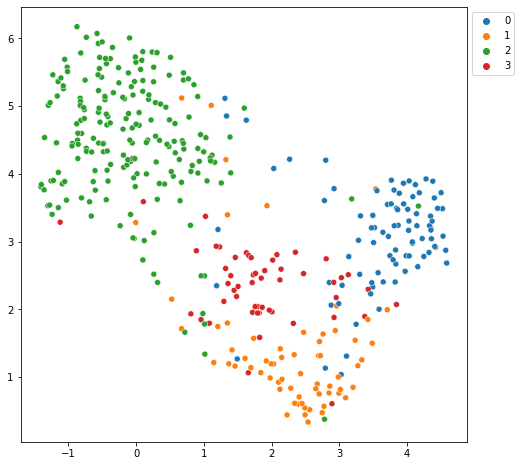

In [7]:
# emb visualization
# model.G access PyG data object
downstream_tasks.visualize_embeddings(model.G, embeddings['author'], node_type='author')

## Similarity Search/Recommendation

In [21]:
# returns top 10 similar authors(ids) along with similarity distance 
distance, nbors = downstream_tasks.similarity_search(embeddings['author'], top_k_nbors=10)

In [22]:
# recommend similar authors based on common research areas and common conferences
nbors

array([[   0,  670,   14, ..., 1132,  230, 2585],
       [   1,   14, 1132, ...,  404,   22, 1730],
       [   2, 3718, 1201, ..., 3784, 3848, 3820],
       ...,
       [4054, 1795, 2235, ..., 1389, 4012, 3991],
       [4055, 3104, 2803, ..., 2530, 1364, 3900],
       [4056, 3979, 2630, ..., 4013, 4006, 3991]])

## Node Classification with Graph Embeddings

In real world most of the datasets are without labels (or have few labels) and often imbalanced. The class imbalance and sparse labels make supervised learning a challenging task. It can also lead to higher false negatives and imbalanced datasets can result in models with more false positives. Hence, training GNNs with unsupervised objectives and using their latent representaion (node embeddings) downstream can provide promising results. Once graph (node) embeddings are generated using unsupervised learning, it can be used as a feature inputs to machine learning classification models to perform the task of node classification. 

Below code shows that even less amount of training data (with labels) i.e 10% can generalize well on the unseen data (test data) which is in contrast with above Metapath2Vec class where we have used 80% of data as training to test the performance of generated graph embeddings.

In [14]:
# Dataset Splitting
X_train, X_test, y_train, y_test = train_test_split(
    embeddings['author'], model.G['author'].y.cpu().numpy(), train_size=0.1, test_size=None, 
    stratify=model.G['author'].y.cpu().numpy(), random_state=42)

In [15]:
# Training with Logistic Regression
clf = LogisticRegression(max_iter=1000, solver="lbfgs")
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [16]:
y_pred = clf.predict(X_test)
# evalute accuracy on test set
accuracy_score(y_test, y_pred)

0.9173055859802848

## Store Graph Embeddings in ArangoDB

In [18]:
model.graph_util.store_embeddings(embeddings['author'], collection_name='author_embeddings', node_type='author')

Output()

Inserting batch the last batch!